In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import ast
import sklearn

In [150]:
means = pd.read_csv("cofactor_expression/mean_expression.csv").set_index("tissueSiteDetailId").T
medians = pd.read_csv("cofactor_expression/median_expression.csv").set_index("tissueSiteDetailId").T
stds = pd.read_csv("cofactor_expression/std_expression.csv").set_index("tissueSiteDetailId").T
counts = pd.read_csv("cofactor_expression/counts_expression.csv").set_index("tissueSiteDetailId").T
GTEXmapper = pd.read_csv("helperfiles/mapper_GTEXcode.csv")
cofactors = pd.read_csv("helperfiles/cofactors_mapped_combined.csv")

In [151]:
cofactors_select = cofactors[["Gene Name", "Complex", "Subcomplex or Module", "UniprotID"]]
merged = cofactors_select.merge(GTEXmapper, on="UniprotID")
merged.head()

,Gene Name,Complex,Subcomplex or Module,UniprotID,Bgee,GeneID,Gene Names,GTEXGeneCode
0,BAF180,BAF,esBAF,Q86U86,ENSG00000163939,55193.0,"['PBRM1', 'BAF180', 'PB1']",ENSG00000163939.18
1,BAF180,BAF,npBAF,Q86U86,ENSG00000163939,55193.0,"['PBRM1', 'BAF180', 'PB1']",ENSG00000163939.18
2,BAF180,BAF,nBAF,Q86U86,ENSG00000163939,55193.0,"['PBRM1', 'BAF180', 'PB1']",ENSG00000163939.18
3,BCL11A,BAF,esBAF,Q9H165,ENSG00000119866,53335.0,"['BCL11A', 'CTIP1', 'EVI9', 'KIAA1809', 'ZNF856']",ENSG00000119866.20
4,BCL11A,BAF,npBAF,Q9H165,ENSG00000119866,53335.0,"['BCL11A', 'CTIP1', 'EVI9', 'KIAA1809', 'ZNF856']",ENSG00000119866.20


In [152]:
GTEXmappermain = merged[["GTEXGeneCode", "Gene Name", "Complex", "Subcomplex or Module"]]
grouped = GTEXmappermain.groupby("GTEXGeneCode").agg(list)
grouped_count = GTEXmappermain.groupby("GTEXGeneCode").agg(len)
grouped[grouped_count["Gene Name"] > 1]

,Gene Name,Complex,Subcomplex or Module
GTEXGeneCode,,,
ENSG00000028310.17,"[BRD9, BRD9, BRD9, BRD9]","[BAF, BAF, BAF, Chromatin Remodelers]","[esBAF, npBAF, nBAF, nan]"
ENSG00000049618.22,"[BAF250B, BAF250B, ARID1B]","[BAF, BAF, Chromatin Remodelers]","[npBAF, nBAF, nan]"
ENSG00000066117.14,"[BAF60A, BAF60A, BAF60A, SMARCD1]","[BAF, BAF, BAF, Chromatin Remodelers]","[esBAF, npBAF, nBAF, nan]"
ENSG00000073584.18,"[BAF57, BAF57, BAF57, SMARCE1]","[BAF, BAF, BAF, Chromatin Remodelers]","[esBAF, npBAF, nBAF, nan]"
ENSG00000080503.22,"[BRM, BRM]","[BAF, BAF]","[npBAF, nBAF]"
ENSG00000082014.16,"[BAF60C, BAF60C, SMARCD3]","[BAF, BAF, Chromatin Remodelers]","[npBAF, nBAF, nan]"
ENSG00000099385.11,"[BCL7C, BCL7C, BCL7C]","[BAF, BAF, BAF]","[esBAF, npBAF, nBAF]"
ENSG00000099956.18,"[BAF47, BAF47, BAF47, SMARCB1]","[BAF, BAF, BAF, Chromatin Remodelers]","[esBAF, npBAF, nBAF, nan]"
ENSG00000106635.7,"[BCL7B, BCL7B, BCL7B]","[BAF, BAF, BAF]","[esBAF, npBAF, nBAF]"


In [153]:
GTEXmappermain = merged[["GTEXGeneCode", "Gene Name", "Complex", "Subcomplex or Module"]]
grouped = GTEXmappermain.groupby("GTEXGeneCode").agg(lambda x: list(set(x.to_list())))
grouped["Gene Name"] = grouped["Gene Name"].apply(lambda x: x[0])

def flatten_and_clean(input_list):
    output_list = []
    
    for item in input_list:
        # If the item is a list, recursively flatten it
        if isinstance(item, list):
            output_list.extend(flatten_and_clean(item))  # Recursion to flatten sublists
        # If the item is NaN, skip it
        elif isinstance(item, float) and math.isnan(item):
            continue
        else:
            output_list.append(item.replace("[", "").replace("]", ""))
        
    return output_list

grouped["Subcomplex or Module"] = grouped["Subcomplex or Module"].apply(flatten_and_clean)

genename = grouped[["Gene Name"]]
medians_gene = np.log(medians.merge(genename, left_index=True, right_index=True).set_index("Gene Name"))
means_gene = np.log(means.merge(genename, left_index=True, right_index=True).set_index("Gene Name"))
stds_gene = stds.merge(genename, left_index=True, right_index=True).set_index("Gene Name")

In [162]:
#Sort columns adn rows highest to lowest
medians = pd.read_csv("cofactor_expression/median_expression.csv").set_index("tissueSiteDetailId")

medians_gene["Net"] = medians_gene.sum(axis=1)
medians_gene = medians_gene.sort_values("Net").drop("Net", axis = 1)
medians_gene.head()

Gene Name,MED12L,BAF53B,BAF45B,BCL11B,BCL11A,BAF45C,POLR2F,SUPT3H,INTS2,MED26,...,CDK9,TAF10,SUPT5H,SSRP1,POLR2E,KAT2A,TRIM28,SF3B5,H2AZ,ACTB
Heart_Left_Ventricle,-2.683578,-3.929356,-1.675923,-2.917501,0.261290,1.605531,-1.179213,0.125674,0.776611,0.484170,...,3.086703,3.709761,3.291346,3.211393,3.664065,3.420597,3.892731,4.364949,4.066020,6.382827
Liver,-3.537102,-3.005083,-3.883352,-1.371438,-2.765942,0.507152,-2.481975,0.012221,0.717543,0.823981,...,3.784588,4.040285,3.717231,3.402415,4.349345,4.095949,3.919481,4.700405,4.002876,6.779350
Pancreas,-2.887692,-0.717928,-2.792813,-2.225458,0.130183,-1.513758,-2.215883,0.957850,0.500552,0.787818,...,3.430806,4.046060,3.601230,3.916020,3.268220,3.919985,4.497201,4.403408,3.920480,6.166147
Whole_Blood,-1.170979,-3.302368,-3.613999,1.524378,0.189820,-1.357852,-2.202407,-0.087015,-0.150578,1.681376,...,3.578310,4.670154,3.650713,3.240513,4.091602,2.859883,4.244030,4.519806,5.198086,8.599927
Heart_Atrial_Appendage,-1.815680,-3.453862,-1.530129,-1.952894,-0.772362,1.517909,-0.330433,0.549851,1.099690,0.874079,...,3.477486,3.901220,3.617433,3.535657,3.890053,3.926640,4.109145,4.542077,4.317860,7.199892


In [163]:
medians_gene = medians_gene.T
medians_gene["Net"] = medians_gene.sum(axis=1)
medians_gene = medians_gene.sort_values("Net").drop("Net", axis = 1)
medians_gene.head()

,Heart_Left_Ventricle,Liver,Pancreas,Whole_Blood,Heart_Atrial_Appendage,Brain_Putamen_basal_ganglia,Brain_Amygdala,Brain_Substantia_nigra,Brain_Hippocampus,Brain_Caudate_basal_ganglia,...,Thyroid,Brain_Cerebellar_Hemisphere,Fallopian_Tube,Nerve_Tibial,Cervix_Ectocervix,Cells_EBV-transformed_lymphocytes,Cervix_Endocervix,Ovary,Uterus,Testis
Gene Name,,,,,,,,,,,,,,,,,,,,,
MED12L,-2.683578,-3.537102,-2.887692,-1.170979,-1.815680,-0.274991,-0.057714,-0.249820,-0.282657,0.163781,...,-0.611594,0.830473,-1.025703,0.286133,0.418081,-0.872018,0.136635,-0.999966,-0.062460,1.291163
BAF53B,-3.929356,-3.005083,-0.717928,-3.302368,-3.453862,3.380787,2.973801,2.397945,3.090538,3.521083,...,-2.442370,4.826325,-2.843145,-2.839371,-3.311600,-3.248787,-3.520015,-2.231577,-3.185519,0.936985
BAF45B,-1.675923,-3.883352,-2.792813,-3.613999,-1.530129,2.424504,2.559148,1.637734,2.668494,2.527784,...,-2.309640,2.723904,-0.970424,-1.466564,-0.982315,-0.154205,-1.062618,-0.739380,-0.841544,1.590806
BCL11B,-2.917501,-1.371438,-2.225458,1.524378,-1.952894,2.336865,1.483627,-0.559906,1.674500,2.476073,...,0.655395,-1.896056,-0.192183,-1.182970,0.638650,-2.340836,-0.525094,-0.784280,-1.109120,0.273720
BCL11A,0.261290,-2.765942,0.130183,0.189820,-0.772362,1.812241,0.685463,0.384418,2.027784,1.958774,...,0.237475,-0.832854,0.108386,-2.330144,0.932661,1.871559,-0.091764,-1.244251,-0.297451,0.136160


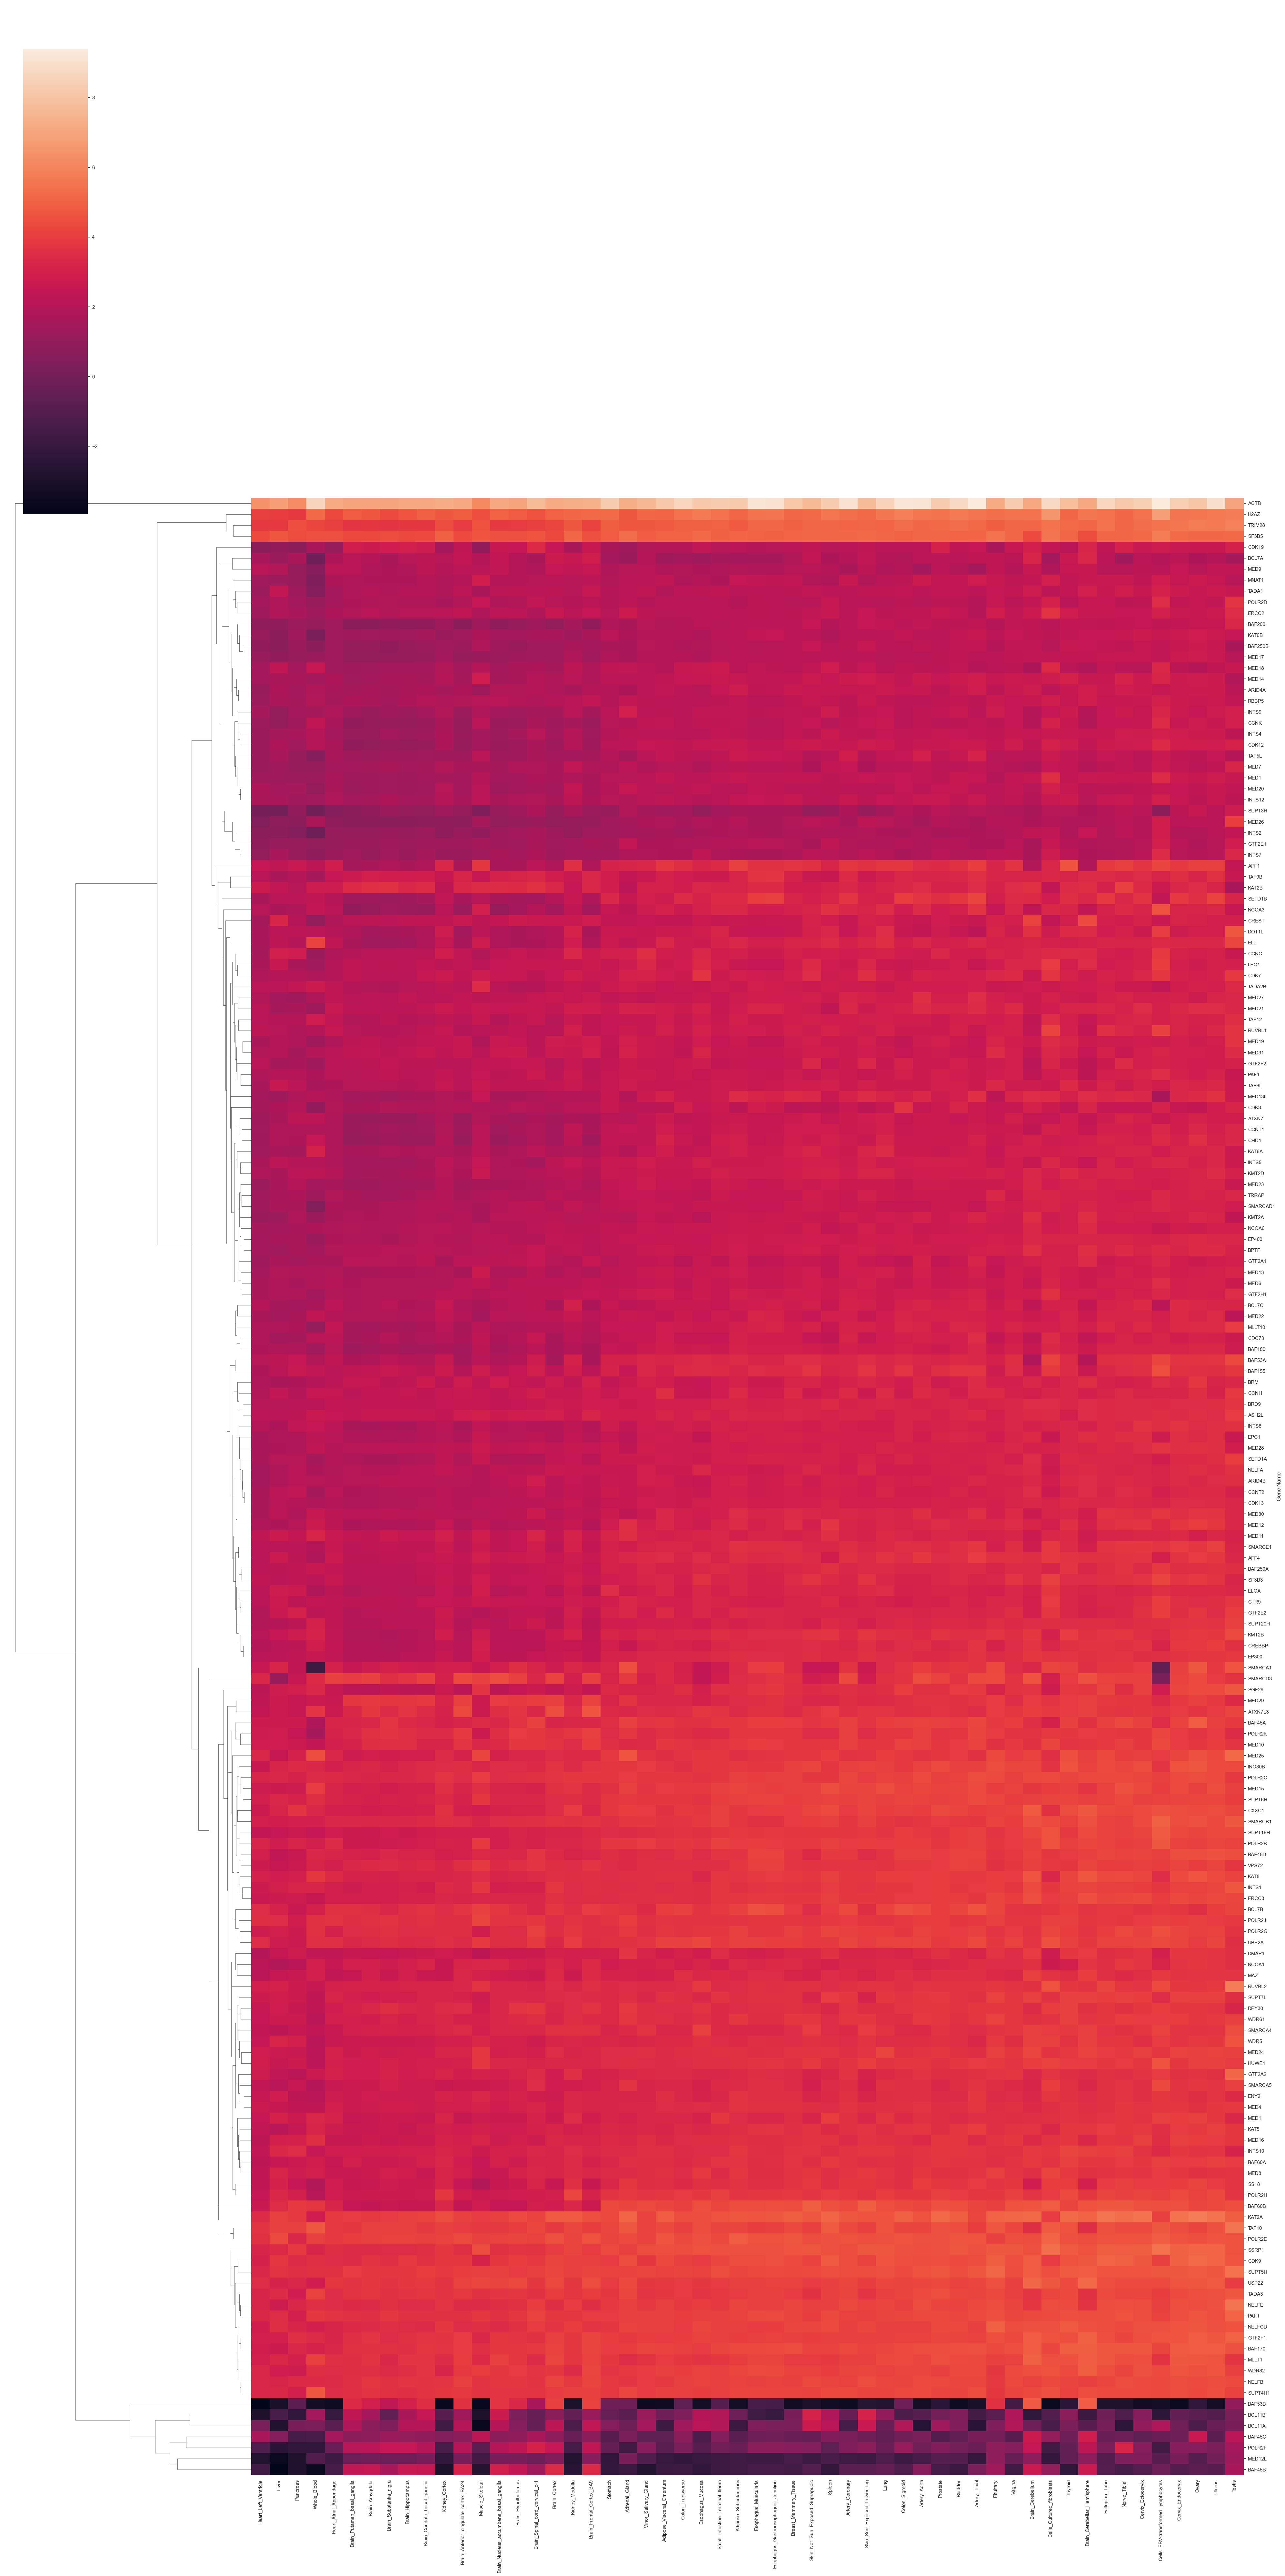

In [164]:
sns.clustermap(medians_gene, figsize=(40, 80), col_cluster=False)

In [200]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

def aggcluster(data, numcclust):
    aggclust = AgglomerativeClustering(n_clusters=numcclust).fit(data)
    clusteringresults = pd.DataFrame({"Gene Name": medians_gene.index, "clusterID": aggclust.labels_})
    clusteringresults = clusteringresults.merge(grouped, on="Gene Name")
    return clusteringresults

def kmeans(data, numclust):
    kmeans = KMeans(n_clusters=numclust, random_state=0, n_init="auto").fit(data)
    clusteringresults = pd.DataFrame({"Gene Name": medians_gene.index, "clusterID": kmeans.labels_})
    clusteringresults = clusteringresults.merge(grouped, on="Gene Name")
    return clusteringresults

aggclustresults = aggcluster(medians_gene, 15)
kmeansclustresults = kmeans(medians_gene, 15)

In [234]:
medians_complex = medians_gene.merge(grouped, right_on="Gene Name", left_index=True).set_index("Gene Name")
medians_complex.head()

,Heart_Left_Ventricle,Liver,Pancreas,Whole_Blood,Heart_Atrial_Appendage,Brain_Putamen_basal_ganglia,Brain_Amygdala,Brain_Substantia_nigra,Brain_Hippocampus,Brain_Caudate_basal_ganglia,...,Fallopian_Tube,Nerve_Tibial,Cervix_Ectocervix,Cells_EBV-transformed_lymphocytes,Cervix_Endocervix,Ovary,Uterus,Testis,Complex,Subcomplex or Module
Gene Name,,,,,,,,,,,,,,,,,,,,,
MED12L,-2.683578,-3.537102,-2.887692,-1.170979,-1.815680,-0.274991,-0.057714,-0.249820,-0.282657,0.163781,...,-1.025703,0.286133,0.418081,-0.872018,0.136635,-0.999966,-0.062460,1.291163,[Mediator],[Kinase]
BAF53B,-3.929356,-3.005083,-0.717928,-3.302368,-3.453862,3.380787,2.973801,2.397945,3.090538,3.521083,...,-2.843145,-2.839371,-3.311600,-3.248787,-3.520015,-2.231577,-3.185519,0.936985,[BAF],[nBAF]
BAF45B,-1.675923,-3.883352,-2.792813,-3.613999,-1.530129,2.424504,2.559148,1.637734,2.668494,2.527784,...,-0.970424,-1.466564,-0.982315,-0.154205,-1.062618,-0.739380,-0.841544,1.590806,[BAF],[nBAF]
BCL11B,-2.917501,-1.371438,-2.225458,1.524378,-1.952894,2.336865,1.483627,-0.559906,1.674500,2.476073,...,-0.192183,-1.182970,0.638650,-2.340836,-0.525094,-0.784280,-1.109120,0.273720,[BAF],"[esBAF, nBAF, npBAF]"
BCL11A,0.261290,-2.765942,0.130183,0.189820,-0.772362,1.812241,0.685463,0.384418,2.027784,1.958774,...,0.108386,-2.330144,0.932661,1.871559,-0.091764,-1.244251,-0.297451,0.136160,[BAF],"[esBAF, nBAF, npBAF]"


BAF Complex Proteins in Brain

In [236]:
brainlabels = [x for x in medians_gene.columns.to_list() if "Brain" in x]
BAF_only = medians_complex[["BAF" in x for x in medians_complex["Complex"]]]
BAF_brain = BAF_only[brainlabels]
BAF_brain.head()

,Brain_Putamen_basal_ganglia,Brain_Amygdala,Brain_Substantia_nigra,Brain_Hippocampus,Brain_Caudate_basal_ganglia,Brain_Anterior_cingulate_cortex_BA24,Brain_Nucleus_accumbens_basal_ganglia,Brain_Hypothalamus,Brain_Spinal_cord_cervical_c-1,Brain_Cortex,Brain_Frontal_Cortex_BA9,Brain_Cerebellum,Brain_Cerebellar_Hemisphere
Gene Name,,,,,,,,,,,,,
BAF53B,3.380787,2.973801,2.397945,3.090538,3.521083,3.626611,3.758403,3.323904,1.674341,4.065548,4.136678,4.767309,4.826325
BAF45B,2.424504,2.559148,1.637734,2.668494,2.527784,3.141177,2.963357,2.432490,1.281229,3.407770,3.395952,2.709516,2.723904
BCL11B,2.336865,1.483627,-0.559906,1.674500,2.476073,1.352000,2.782053,0.333128,-0.421272,0.785520,1.218815,-2.264940,-1.896056
BCL11A,1.812241,0.685463,0.384418,2.027784,1.958774,1.997323,1.953564,0.582754,-0.466979,2.268166,2.387512,-0.179442,-0.832854
BAF45C,0.795554,0.839311,1.215192,0.972922,0.891386,0.661366,0.723349,0.868560,1.610708,0.827164,0.708168,2.772761,2.889190


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
brain_PCA = pd.DataFrame(pca.fit_transform(BAF_brain)).rename({0: "PCA1-B", 1:"PCA2-B"}, axis=1)
brain_PCA["Gene Name"] = BAF_brain.index
brain_PCA = brain_PCA.set_index("Gene Name")

brain_PCA.head()

,PCA1-B,PCA2-B
Gene Name,,
BAF53B,-3.383028,0.646937
BAF45B,0.102750,1.342823
BCL11B,7.866250,4.459823
BCL11A,5.946421,3.007570
BAF45C,4.486562,-2.882410


In [252]:
BAF_only = medians_complex[["BAF" in x for x in medians_complex["Complex"]]]
nobrainlabels = [x for x in medians_gene.columns.to_list() if "Brain" not in x]
BAF_nobrain = BAF_only[nobrainlabels]

pca = PCA(n_components=2)
nobrain_PCA = pd.DataFrame(pca.fit_transform(BAF_nobrain)).rename({0: "PCA1-NB", 1:"PCA2-NB"}, axis=1)
nobrain_PCA["Gene Name"] = BAF_nobrain.index
nobrain_PCA = nobrain_PCA.set_index("Gene Name")

nobrain_PCA.head()

,PCA1-NB,PCA2-NB
Gene Name,,
BAF53B,31.755906,-2.563415
BAF45B,24.740497,-3.799754
BCL11B,17.581811,6.859557
BCL11A,16.438035,7.292608
BAF45C,15.649187,-4.542367


<Axes: ylabel='Gene Name'>

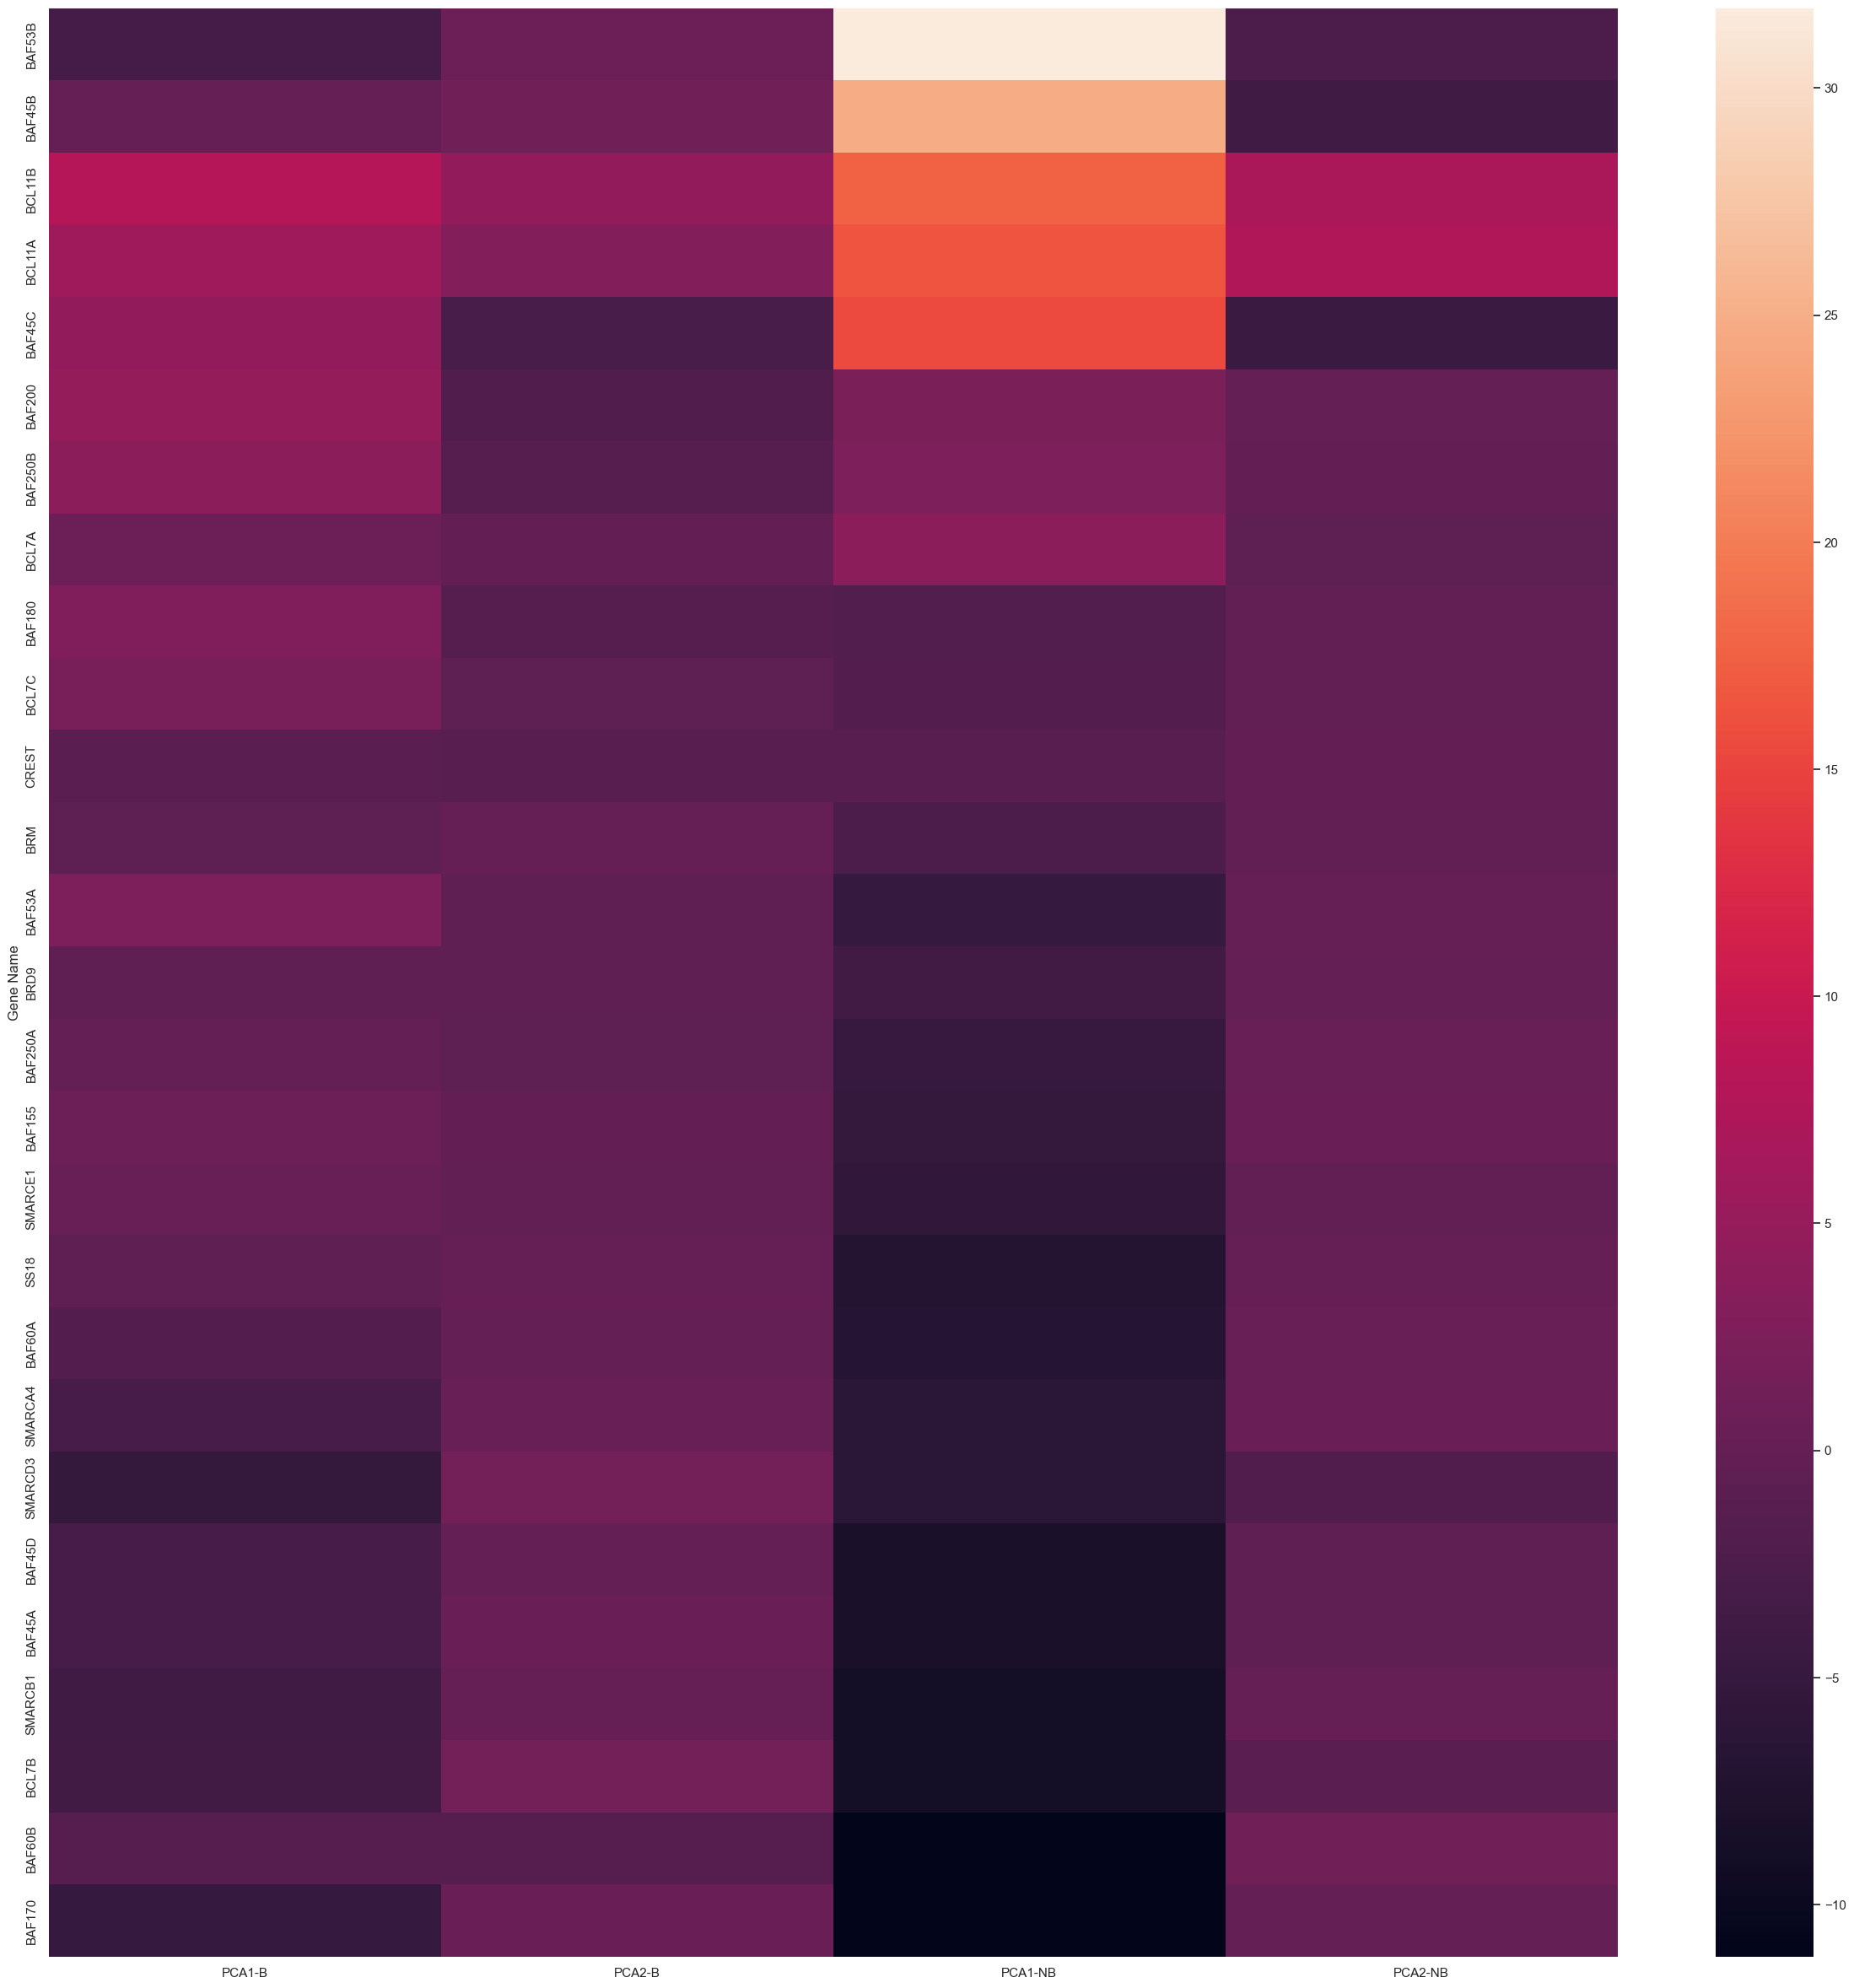

In [256]:
braionconcat = brain_PCA.merge(nobrain_PCA, left_index=True, right_index=True)
sns.heatmap(braionconcat)

In [214]:
medians_gene.columns.to_list()

['Heart_Left_Ventricle',
 'Liver',
 'Pancreas',
 'Whole_Blood',
 'Heart_Atrial_Appendage',
 'Brain_Putamen_basal_ganglia',
 'Brain_Amygdala',
 'Brain_Substantia_nigra',
 'Brain_Hippocampus',
 'Brain_Caudate_basal_ganglia',
 'Kidney_Cortex',
 'Brain_Anterior_cingulate_cortex_BA24',
 'Muscle_Skeletal',
 'Brain_Nucleus_accumbens_basal_ganglia',
 'Brain_Hypothalamus',
 'Brain_Spinal_cord_cervical_c-1',
 'Brain_Cortex',
 'Kidney_Medulla',
 'Brain_Frontal_Cortex_BA9',
 'Stomach',
 'Adrenal_Gland',
 'Minor_Salivary_Gland',
 'Adipose_Visceral_Omentum',
 'Colon_Transverse',
 'Esophagus_Mucosa',
 'Small_Intestine_Terminal_Ileum',
 'Adipose_Subcutaneous',
 'Esophagus_Muscularis',
 'Esophagus_Gastroesophageal_Junction',
 'Breast_Mammary_Tissue',
 'Skin_Not_Sun_Exposed_Suprapubic',
 'Spleen',
 'Artery_Coronary',
 'Skin_Sun_Exposed_Lower_leg',
 'Lung',
 'Colon_Sigmoid',
 'Artery_Aorta',
 'Prostate',
 'Bladder',
 'Artery_Tibial',
 'Pituitary',
 'Vagina',
 'Brain_Cerebellum',
 'Cells_Cultured_fibrobla